--- Google Drive 接続用設定 ---

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
!ls gdrive/My\ Drive

Colab Notebooks      test_1.zip		  train_0000054.jpg
resume_english.docx  test_sig_model.json  train_1.zip
submit.tsv	     test_sig_weights.h5  train_2.zip


--- ここまで ---

In [15]:
!unzip -q gdrive/My\ Drive/train_1.zip
#!unzip -q drive/train_2.zip
#!unzip -q drive/test_1.zip
!ls

gdrive	sample_data  train


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
batch_size = 128
num_classes = 2
epochs = 12

# input image dimensions
img_rows, img_cols = 64, 64

In [18]:
#-- load train data

x = []
y = []

folder = ["nonTC/","TC/"]

for idx, name in enumerate(folder):
    dpath = "train/"+name+"*.tif"
    files = glob.glob(dpath)
    for j, file in enumerate(files):
        img = cv2.imread(file,-1)
        img = np.asarray(img)
        #print(img.shape)
        x.append(img)
        y.append(idx)

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(148450, 64, 64)
(148450,)


In [0]:
#-- split train/test data

from sklearn.model_selection import train_test_split 

x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size=0.2, random_state=111)


x_trn = x_trn.reshape(x_trn.shape[0], 4096)
x_tst = x_tst.reshape(x_tst.shape[0], 4096)
y_trn = y_trn.reshape(y_trn.shape[0], 1)
y_tst = y_tst.reshape(y_tst.shape[0], 1)

In [20]:
print(y_trn.shape)
print(y_trn[:5])
print(y_trn.sum(axis=0))
print(y_tst.sum(axis=0))

(118760, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]
[3179]
[870]


In [21]:
#-- ready data

x_trn = x_trn.reshape(x_trn.shape[0], img_rows, img_cols, 1)
x_tst = x_tst.reshape(x_tst.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('x_trn shape:', x_trn.shape)
print(x_trn.shape[0], 'train samples')
print(x_tst.shape[0], 'test  samples')

#-- convert class vectors to binary class matrices
y_trn = keras.utils.to_categorical(y_trn, num_classes)
y_tst = keras.utils.to_categorical(y_tst, num_classes)


x_trn shape: (118760, 64, 64, 1)
118760 train samples
29690 test  samples


In [0]:
#--- create original model

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [23]:
from keras.models import model_from_json
#from keras.models import load_model

#-- load existing model
model = model_from_json(open('gdrive/My\ Drive/test_sig_model.json').read())

#-- load train result
model.load_weights('gdrive/My\ Drive/test_sig_weights.h5')

#model = load_model("gdrive/My\ Drive/test_sig_model.h5")

FileNotFoundError: ignored

In [0]:
#-- compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


In [26]:
#-- show structure

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

In [0]:
#-- run train
hist = model.fit(
          x_trn, y_trn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_tst, y_tst))

score = model.evaluate(x_tst, y_tst, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 118760 samples, validate on 29690 samples
Epoch 1/12
118760/118760 [==============================] - 202s 2ms/step - loss: 0.1097 - acc: 0.9731 - val_loss: 0.0939 - val_acc: 0.9707
Epoch 2/12
118760/118760 [==============================] - 197s 2ms/step - loss: 0.0894 - acc: 0.9737 - val_loss: 0.0899 - val_acc: 0.9708
Epoch 3/12
118760/118760 [==============================] - 197s 2ms/step - loss: 0.0827 - acc: 0.9750 - val_loss: 0.0925 - val_acc: 0.9731
Epoch 4/12
 14976/118760 [==>...........................] - ETA: 2:41 - loss: 0.0742 - acc: 0.9769

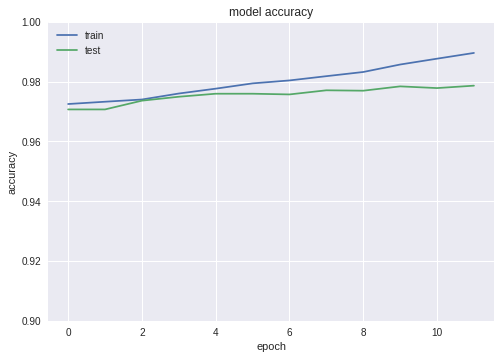

In [16]:
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.ylim([0.9,1.0])
plt.show()

In [25]:
from sklearn.metrics import classification_report
#from sklearn.metrics import precision_recall_fscore_support

y_evl = model.predict(x_tst, batch_size=batch_size)
y_evl2 = np.argmax(y_evl,axis=1)
y_tst2 = np.argmax(y_tst,axis=1)
print(classification_report(y_tst2, y_evl2))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     28820
          1       0.80      0.36      0.50       870

avg / total       0.98      0.98      0.97     29690



In [0]:
#--- save model weight
json_string = model.to_json()
open('gdrive/My\ Drive/test_sig_model.json', 'w').write(json_string)
model.save_weights('gdrive/My\ Drive/test_sig_weights.h5')

#model.save('drive/test_sig_model.h5')

--- 提出用 ---

In [0]:
#-- submit用 --
import os

x_s = []
f_s = []

dpath = "test/*.tif"
files = glob.glob(dpath)

for i, file in enumerate(files):
  img = cv2.imread(file,-1)
  img = np.asarray(img)
  fnm = os.path.basename(file)  
  x_s.append(img)
  f_s.append(fnm)
  

In [13]:
x_s = np.asarray(x_s)

print(x_s.shape)
x_s = x_s.reshape(x_s.shape[0], img_rows, img_cols, 1)

(148563, 64, 64)


In [0]:
#-- predict
y_s = model.predict(x_s, batch_size=batch_size)

y_s2 = np.argmax(y_s,axis=1)

In [42]:
#-- save submit data
df_y = pd.Series(y_s2)
df_f = pd.Series(f_s)

df_o = pd.concat([df_f, df_y],axis=1)
df_o.head()

df_o.to_csv("gdrive/My\ Drive/submit.tsv", sep='\t', index=False, header=False)


,0,1
0,test_145015.tif,0
1,test_212861.tif,0
2,test_096873.tif,0
3,test_250471.tif,0
4,test_164362.tif,0
